In this chapter we will apply a few state-of-the-art techniques in supervised learning. These techniques include Gredient Boosting, Xgboost, Neural Network.

Pozzolo et. al (2015) published a [credit card transactions dataset](https://www.kaggle.com/dalpozz/creditcardfraud) on Kaggle.com for the data science community. This highly unbalanced dataset contains 284,807 transactions and 492 frauds. For confidentiality purpose, all the original features have been disguised and converted to V1-V28 using the principal components.

We have learned the treatment for highly imbalanced data in previous chapter. So we will apply resampling method. We have also learned the need to use the Precision-Recall curve rather than the ROC curve to measure the accuracy. 

### Under-sampling the dataset

The dataset is imbalanced. In previous chapter we have demonstrated various under-sampling or over-sampling techniques in treating imbalanced data. Here we will just use simple random under-sampling technique so we can spend more time on surpervised learning methods. In case study session readers are guided to apply other resampling methods.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
CreditCard = pd.read_csv("/Users/chriskuo/Downloads/creditcard.csv")
CreditCard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
from sklearn import preprocessing
CreditCard.Amount = preprocessing.scale(CreditCard.Amount)
X = CreditCard.drop('Class',axis=1)
y = CreditCard['Class']
CreditCard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)
y_train.value_counts()

0    199032
1       332
Name: Class, dtype: int64

In [6]:
from imblearn.datasets import make_imbalance
X_down_random, y_down_random = make_imbalance(X_train, y_train, ratio={1: 332, 0: 996},
                      random_state=0)

unique, counts = np.unique(y_down_random, return_counts=True)
dict(zip(unique, counts))

{0: 996, 1: 332}

In [7]:
# https://datascience.stackexchange.com/questions/14377/tuning-gradient-boosted-classifiers-hyperparametrs-and-balancing-it

# http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
import time

gbm_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                   'max_depth': [4, 6, 8],
                   'min_samples_leaf': [20, 50,100,150]
                  }
print(gbm_grid_params)

gbm_grid = ensemble.GradientBoostingClassifier(n_estimators = 600)

gbm = GridSearchCV(gbm_grid,
                   gbm_grid_params,
                   cv=2,
                   scoring='roc_auc',
                   verbose = 0, 
                   n_jobs=10);

t0 = time.time()
gbm.fit(X_down_random, y_down_random);
gbm_time = time.time() - t0
print("gbm fit in %.3f s" % gbm_time)

{'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]}
gbm fit in 46.961 s


GridSearchCV can output all the key information such as best_estimator_, best_score_, best_params_, cv_results_. For all the attributes, please click [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [8]:
gbm.best_estimator_, gbm.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=6,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=100, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=600,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False), 0.97774229447912131)

In [35]:
gbm_y_score = gbm.decision_function(X_test)
gbm_y_score

array([-11.62788125, -11.70117345,  -5.95260495, ..., -12.27561068,
       -13.49991238,   0.74301006])

In [36]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
average_precision = average_precision_score(y_test, gbm_y_score)
auc = roc_auc_score(y_test, gbm_y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Area under the curve: {0:0.2f}'.format(auc))

Average precision-recall score: 0.75
Area under the curve: 0.98


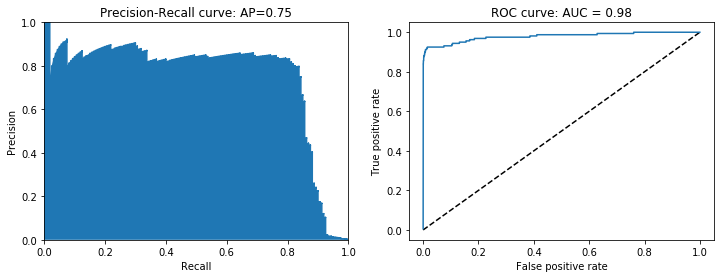

In [62]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def Precision_recall_ROC_curves(y_test,y_score):
    # Precision-recall curve, the average precision score
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.figure(figsize=(12, 4)) 
    plt.subplot(1, 2, 1)
    plt.step(recall, precision)
    plt.fill_between(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

    # ROC curve, AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve: AUC = {0:0.2f}'.format(auc))
    plt.show()
    
Precision_recall_ROC_curves(y_test,y_score)    

### Xgboost 

XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting” is proposed in the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoo

[xgboost](http://xgboost.readthedocs.io/en/latest/model.html)


The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost. For model, it might be more suitable to be called as regularized gradient boosting.

Both xgboost and gbm follows the principle of gradient boosting. There are however, the difference in modeling details. Specifically, xgboost used a more regularized model formalization to control over-fitting, which gives it better performance.

In [16]:
#!pip install xgboost
# https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_on_Mac_OSX
    

In [15]:
#import lightgbm as lgb

### What is Deep Learning?

Deep learning, a branch of machine learning methods, is inspired analogically by the neural network of the brain. So a deep learning model is often called an artificial neural network (ANN). But to learn deep learning, we actually do not need a whole lot of knowledge in biology. In a brain there exists enomous neural networks. 

<img src="a cat.png" alt="Drawing" align="right" style="width: 500px;"/>

The basic unit of a neural network is the neuron. If we use computer terminology to explain, we will say each neuron has a set of inputs, each of which is given a specific weight. The neuron computes some function on these weighted inputs and outputs a decision. The “deep” in deep learning signifies the use of many layers of neural networks. The figure shows an eye sees a cat and recognizes it as a cat.

##### What are the applications?

Deep learning is a hot term when people talk about Artificial Intelligence (AI), Big Data and machine learning (ML). In image recognition, deep learning is applied to sort through the millions of images. More images of the same classification are presented when you search for images. In video recognition, videos of similar contents can be segmented together to present to users. In natural language processing, deep learning can classifies texts, recognize voices or speeches, summarize a document or even answer questions. It sets a step closer to AI, which has been showing great promise for autonomous and self-learning systems. In the avigation of self-driving cars, cars are learning to recognize obstacles and react to them appropriately using Deep Learning.

##### How does deep learning work?

Recently I join a book club. I am trying to decide which book I should read. In the book club everyone gives a rating 1 to 5 for the books he or she read before. Below is a list of the classic books the ratings of my friends Abel, Bob, Chuck and Dick. I am deciding if I should read Jane Austen's "Pride and Prejudice". I see my friends' ratings for this book are 2, 3, 3, 5 respectively. Should I pick up this book? Maybe there are connections between my past decisions and their ratings? Can we train a neural network model to formulate the relationships so as to predict my decision?

|Book | Abel | Bob | Chuck | Dick | I like it or not |
|:-- |:--: |:--: | :--: |:--: |:--: |
|In Search of Lost Time by Marcel Proust | 4 | 3 | 4 | 5 | Yes|
|Ulysses by James Joyce                  | 2 | 3 | 3 | 4 | Yes|
|The Odyssey by Homer                    | 4 | 2 | 4 | 2 | No |
|Hamlet by William Shakespeare           | 3 | 4 | 1 | 1 | No |
|The Great Gatsby by F. Scott Fitzgerald | 4 | 1 | 2 | 5 | Yes|
|......                                  |   |   |   |   |    |
|Pride and Prejudice by Jane Austen      | 2 | 3 | 3 | 5 | ?  |

In this case the neural network algorithm trains the model with the ratings of the four friends. So their ratings are the input variables. There are two layers in the neural network with 3 nodes in the first hidden layer and 2 nodes in the second layer. I will explain how the number of nodes is determined later. Each node had three weights to the nodes. Each hidden node receives the 4 inputs multiplied by their respective weights. Each node sums up the contributions from all the x multiplied by their respective weights. A random bias value is added. Then the result is passed through the activation function. The term 'activation function' comes from computer chip circuit that can be "ON" (1) or "OFF" (0). In the second layer, all the outputs become the inputs for the nodes. The same procedure follows to get to the final output.

<img src="My hidden layers.png" alt="Drawing" style="width: 500px;"/>

[A Neural Network Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.78665&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) provides a very nice interface for readers to see the dynamics of the neural networks. Deep learning stems from a long history of research. Readers who are interesed in the historical development are recommended to review Schmidhuber's 
[Deep learning in neural networks: An overview](http://www2.econ.iastate.edu/tesfatsi/DeepLearningInNeuralNetworksOverview.JSchmidhuber2015.pdf) for the evolution of the development.

### Deep learning using Keras

[Keras](https://keras.io/) is a wrapper built on [Tensorflow](https://www.tensorflow.org/) or [Theano](https://github.com/Theano/Theano). It provides an elegant and simplifies coding environment. Besides this, what are other benefits that I recommend Keras? Grid search. In previous chapter we use *GridSearchCV* for gbm to tune the optimal hyperparaters. Likewise, Keras can be easily called by scikit learn and works well with *GridSearchCV*. An neural network can basically open numerous combinations of number of layers and nodes, it can be very cubersome to manually find the optimal combination. I am indebted to Jason Brownlee who contributes to [the grid search with Keras](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/). In the following code we will first define a function for the Keras model. Then call the function with GridSearchCV for grid search. The two most important hyperparameters in Keras for grid search are *batch size* and *number of epochs*. 


##### Step 1: build the layers
We will first declair a Keras model with Sequential(), which means the layers will be stacked on top of each other sequentially. We will stack our layers for our book club example like the following:


<img src="Sequential.png" alt="Drawing" style="width: 600px;"/>

The first layer has 3 nodes and expects 4 inputs. The activation function is 'ReLu'. You only need to enter the input dimensions once. After the 1st layer, you don't need to define it. The second layer has 2 nodes and the activation function is again 'Relu'. The output layer has one node with 'Sigmoid' as the activation function. The common activation functions are: 


<img src="sigmoid_relu.png" alt="Drawing" align="right", style="width: 300px;"/>

* Rectified linear unit (ReLU): $f(y) = max(0,y)$, 
* Sigmoid: $f(y) = \frac{1}{(1+exp(-y))}$, 
* Tanh: $f(y) = tanh(y) $,
* Linear: $f(y) = y$.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

# Step 1: declare the sequential model, and add layers
model = Sequential()
model.add(Dense(3, input_dim=30, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

##### Step 2: Define the loss function and the optimizer

Like all the machine learning algorithms, an objective function or called loss function is required to train the model. The learning process searches the weights to minimize the loss function. The common loss functions include *mean squared error (MSE)*, *mean absolute error (MAE)*, etc. The optimizer is the method to minimize the loss function. The optimizer in the following code is *Stochastic Gradient Descent (SGD)*. 

In [ ]:
# Step 2: configure its learning process with 'compile'
sgd = optimizers.SGD(lr=0.1,decay=1e-6,momentum=0.9)
model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['accuracy'])

##### Step 3: Fit the model
The syntax to train the model is fit(), which is very similar to other scikit models. There are two important hyperparameters. The first one defines how many iterations, called *epochs*, the training process will take run through the dataset. The second one defines the number of records, called *batch size*, to be evaluated before a weight update in the network. In the code we run for 300 iterations and a small batch size of 10. These two variables will determine how time-consuming the training progress will be, depending on CPU or GPU is used. We will discuss the use of GridSearchCV in scikit learn to conduct a grid search.

In [ ]:
# Step3: Fit the model
model.fit(X, Y, epochs=300, batch_size=10)

### Keras for credit card fraud detection
We will apply the above Keras model to the credit card dataset X_down_random and y_down_random. Remember X_down_random has 30 input variables. So *input_dim* is set to 30.

In [70]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

# Step 1: declare the sequential model, and add layers
keras_model = Sequential()
keras_model.add(Dense(3, input_dim=30, activation='relu'))
keras_model.add(Dense(2, activation='relu'))
keras_model.add(Dense(1, activation='sigmoid'))

# Step 2: configure its learning process with 'compile'
sgd = optimizers.SGD(lr=0.1,decay=1e-6,momentum=0.9)
keras_model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['accuracy'])

# Step3: Fit the model
keras_model.fit(X_down_random, y_down_random, epochs=300, batch_size=10)

Epoch 1/300
1328/1328 [==============================] - 2s 1ms/step - loss: 0.1917 - acc: 0.7500
Epoch 2/300
1328/1328 [==============================] - 0s 184us/step - loss: 0.1881 - acc: 0.7500
Epoch 3/300
1328/1328 [==============================] - 0s 184us/step - loss: 0.1896 - acc: 0.7500
Epoch 4/300
1328/1328 [==============================] - 0s 188us/step - loss: 0.1881 - acc: 0.7500
Epoch 5/300
1328/1328 [==============================] - 0s 190us/step - loss: 0.1883 - acc: 0.7500
Epoch 6/300
1328/1328 [==============================] - 0s 187us/step - loss: 0.1877 - acc: 0.7500
Epoch 7/300
1328/1328 [==============================] - 0s 190us/step - loss: 0.1881 - acc: 0.7500
Epoch 8/300
1328/1328 [==============================] - 0s 183us/step - loss: 0.1882 - acc: 0.7500
Epoch 9/300
1328/1328 [==============================] - 0s 187us/step - loss: 0.1883 - acc: 0.7500
Epoch 10/300
1328/1328 [==============================] - 0s 213us/step - loss: 0.1895 - acc: 0.7500
E

1328/1328 [==============================] - 0s 190us/step - loss: 0.1882 - acc: 0.7500 0s - loss: 0.1903 - acc: 0.74
Epoch 161/300
1328/1328 [==============================] - 0s 179us/step - loss: 0.1883 - acc: 0.7500
Epoch 162/300
1328/1328 [==============================] - 0s 176us/step - loss: 0.1882 - acc: 0.7500
Epoch 163/300
1328/1328 [==============================] - 0s 181us/step - loss: 0.1884 - acc: 0.7500
Epoch 164/300
1328/1328 [==============================] - 0s 178us/step - loss: 0.1883 - acc: 0.7500
Epoch 165/300
1328/1328 [==============================] - 0s 179us/step - loss: 0.1884 - acc: 0.7500
Epoch 166/300
1328/1328 [==============================] - 0s 187us/step - loss: 0.1884 - acc: 0.7500
Epoch 167/300
1328/1328 [==============================] - 0s 177us/step - loss: 0.1885 - acc: 0.7500
Epoch 168/300
1328/1328 [==============================] - 0s 179us/step - loss: 0.1888 - acc: 0.7500
Epoch 169/300
1328/1328 [==============================] - 0s 178u

### Keras with grid-search for fraud detection

As mentioned earlier, there are two important hyperparameters: epochs (number of iterations) and batch size. This session will demonstrate how to do grid search to optimize the result. Scikit learn provides a wrapper KerasClassifier. KerasClassifier and GridSearchCV work seemlessly because both are in scikit-learn. In the following code we first wrap the above model in a function called create_model(). Then build the model by KerasClassifier in scikit-learn. Then we conduct the GridSearchCV in scikit-learn. We will do the following steps on the credit card dataset:

<ol>
  <li>Build the Keras model in a function</li>
  <li>Grid search</li>
  <li>Evaluate the model with the test dataset</li>
</ol> 


In [98]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

# Step 1: Build the Keras model in a function
def create_model():
    # declair the sequential model, and add layers
    model = Sequential()
    model.add(Dense(20, input_dim=30, activation='relu')) # 30 input variables
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # configure its learning process with 'compile'
    sgd = optimizers.SGD(lr=0.1,decay=1e-6,momentum=0.9)
    model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['accuracy'])
    return model

# create model
kerasClassifier_model = KerasClassifier(build_fn=create_model, verbose=0)

# Step 2: Grid search for the down-sampled datasets X_down_random, y_down_random
batch_size = [50,100]
epochs = [500, 1000, 2000, 3000, 4000]
param_grid = dict(batch_size=batch_size, epochs=epochs)
keras_grid = GridSearchCV(estimator=kerasClassifier_model, param_grid=param_grid)
keras_grid_model = keras_grid.fit(np.asarray(X_down_random), np.asarray(y_down_random))
# Output the best score and the best parameters
keras_grid_model.best_score_, keras_grid_model.best_params_

KeyboardInterrupt: 

In [97]:
# Step 3: Evaluate the model with the test result
# Keras accepts only array type, so we convert X_test to an array
keras_grid_y_score = keras_grid_model.predict(np.asarray(X_test))
np.unique(keras_grid_y_score, return_counts=True)

(array([0]), array([85443]))

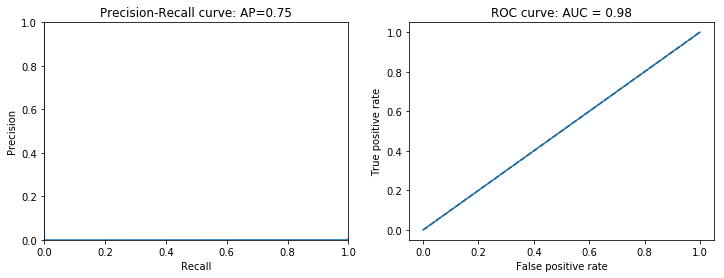

In [92]:
# Step 3: Evaluate the model with the test result
# Keras accepts only array type, so we convert X_test to an array
keras_grid_y_score = keras_grid_model.predict(np.asarray(X_test))
keras_grid_y_score
# Plot the Precision-recall and ROC curves
Precision_recall_ROC_curves(y_test,keras_grid_y_score)

In [ ]:
# https://github.com/fchollet/keras/blob/master/examples/mnist_sklearn_wrapper.py
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# https://www.kaggle.com/randyrose2017/using-scikit-learn-and-keras-for-fraud-detection

##### References

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015